# Misura di plateau di efficienza

Questo codice genera un campione di particelle e la risposta di un ipotetico trigger che ha un'efficienza a soglia.

In [12]:
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt
import math

In [13]:
pdf = gamma(3,scale=10)

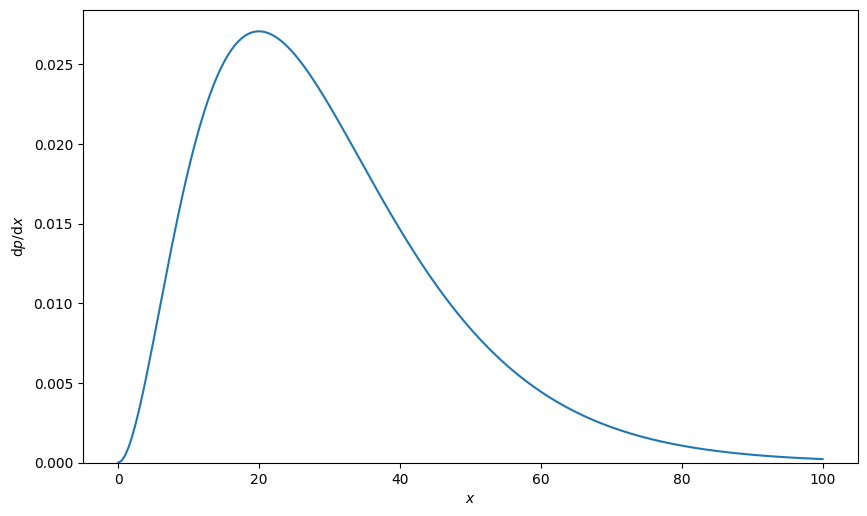

In [14]:
plt.figure(figsize=(10,6), dpi=100)
xs = np.linspace(0,100,200)
ys = pdf.pdf(xs)
plt.plot(xs, ys)
plt.ylim(0)
plt.xlabel('$x$')
plt.ylabel('$\mathrm{d}p/\mathrm{d}x$')
plt.show()

In [15]:
def eff(x):
    return 0.96/(1+np.exp(-0.2*(x-20)))

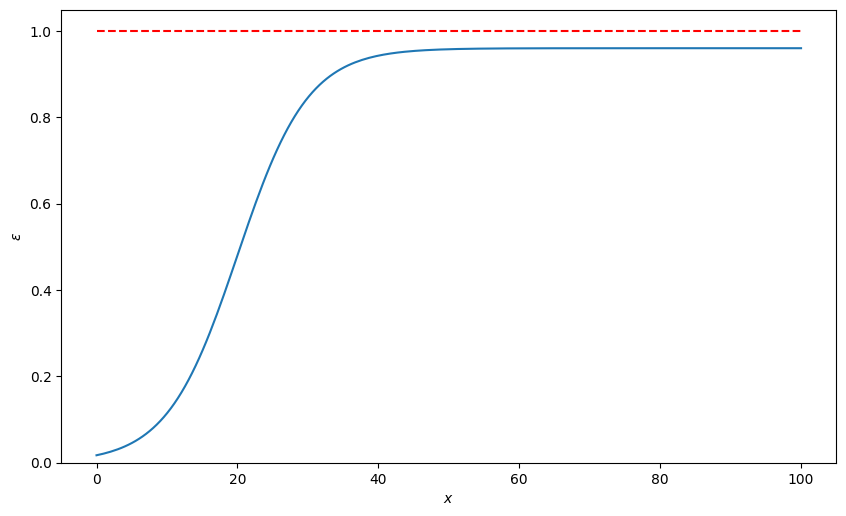

In [16]:
plt.figure(figsize=(10,6), dpi=100)
xs = np.linspace(0,100,200)
ys = eff(xs)
plt.plot(xs, ys)
plt.plot([0,100], [1,1], color='r', linestyle='--')
plt.ylim(0)
plt.xlabel('$x$')
plt.ylabel(r'$\varepsilon$')
plt.show()

In [6]:
x_sample = pdf.rvs(size=10000)

In [7]:
hit_sample = [np.random.random() < eff(x) for x in x_sample]

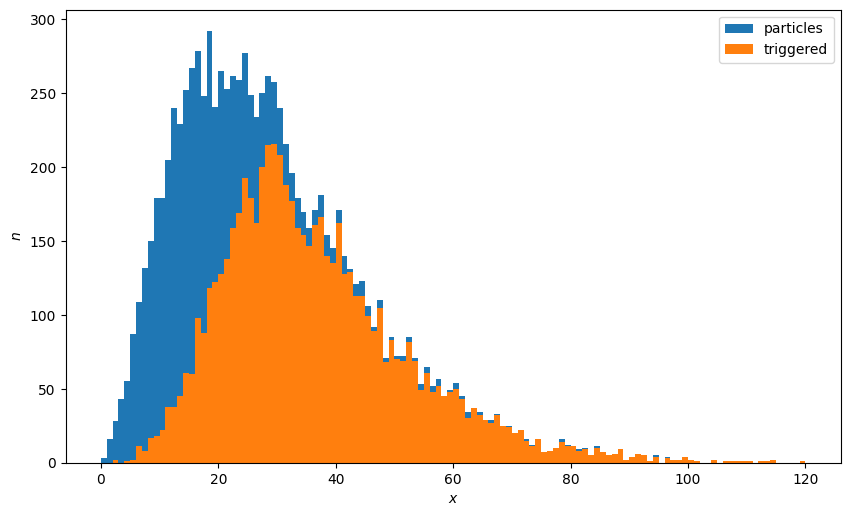

In [8]:
plt.figure(figsize=(10,6), dpi=100)
n_x, bins_x, patches_x = plt.hist(x_sample, label='particles', bins=120, range=(0,120))
n_h, bins_h, patches_h = plt.hist(x_sample[hit_sample], label='triggered', bins=120, range=(0,120))
plt.xlabel('$x$')
plt.ylabel('$n$')
plt.legend()
plt.show()

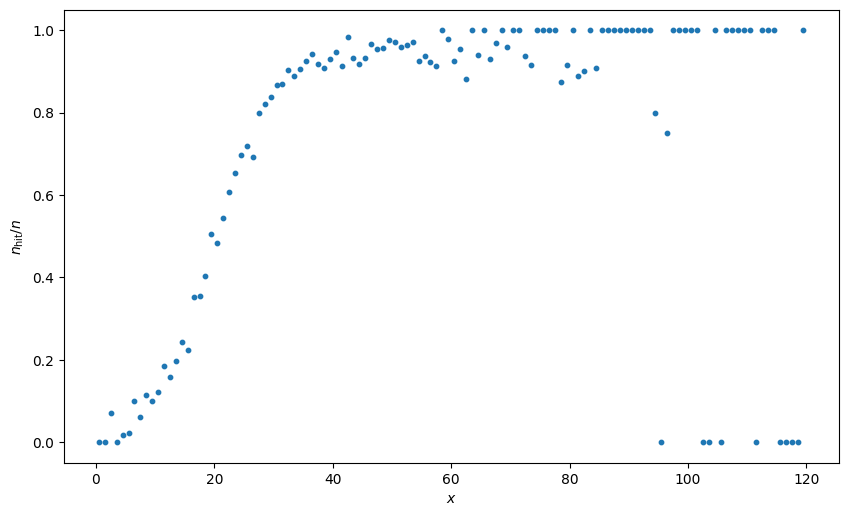

In [9]:
plt.figure(figsize=(10,6), dpi=100)
plt.scatter(bins_x[:-1]+0.5, np.divide(n_h, n_x, out=np.zeros_like(n_x), where=n_x!=0), s=10)
plt.xlabel('$x$')
plt.ylabel('$n_{\mathrm{hit}}/n$')
plt.show()

In [10]:
import pandas as pd
data = {'x': x_sample, 'hit': hit_sample}
df = pd.DataFrame(data=data)

In [11]:
df.to_csv('output/trigger.csv')

# Esercizio

A partire da questi dati, misuerare l'andamento dell'efficienza in funzione di $x$ ed in particolare determinare l'efficienza di *plateau* (ossia: asintotica).